In [20]:
import sys

sys.argv = ['']
sys.path.append("../..")
from src.grid_world import GridWorld
from examples.agent import Agent
import torch.nn as nn
from torch.optim import Optimizer
from torch import optim
import random
import numpy as np
import collections
from tqdm import tqdm
import torch


In [21]:
class QNet(nn.Module):
    """
    Q(s, a) 网络
    输入: state one-hot + action one-hot
    输出: Q值
    """
    def __init__(self, num_states, num_actions):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(num_states + num_actions, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
class DQN(Agent):
    def __init__(self, env, num_episodes=5000, episode_length=1000,
                 gamma=0.9, alpha=0.1, epsilon=0.1):
        """
        Sarsa (on-policy TD control)
        """
        super().__init__(
            env=env,
            epsilon=epsilon,
            gamma=gamma,
            num_episodes=num_episodes,
            episode_length=episode_length
        )
        self.alpha = alpha

        self.QNet = QNet(self.num_states, self.num_actions)
        self.optimizer = optim.Adam(self.QNet.parameters(), lr=self.alpha)
        self.loss_fn = nn.MSELoss()

    # One-hot 编码
    def encode_state_action(self, s_idx, a_idx):
        s_onehot = torch.zeros(self.num_states)
        s_onehot[s_idx] = 1.0
        a_onehot = torch.zeros(self.num_actions)
        a_onehot[a_idx] = 1.0
        sa = torch.cat([s_onehot, a_onehot]).unsqueeze(0)  # shape (1, num_states+num_actions)
        return sa.float()

    # Q值
    def q_value(self, s_idx, a_idx):
        sa = self.encode_state_action(s_idx, a_idx)
        return self.QNet(sa)

    def choose_action(self, state):
        s_idx = self.state2idx(state)
        probs = self.policy[s_idx]
        a_idx = np.random.choice(np.arange(self.num_actions), p=probs)
        return self.idx2action(a_idx)

    def update_policy(self, s_idx):
        q_values = [self.q_value(s_idx, a).item() for a in range(self.num_actions)]
        best_a = np.argmax(q_values)
        self.policy[s_idx] = np.ones(self.num_actions) * self.epsilon / self.num_actions
        self.policy[s_idx][best_a] += 1 - self.epsilon

    def run(self):
        for episode in range(self.num_episodes):
            self.env.reset()
            st = self.env.start_state
            at = self.choose_action(st)

            for t in range(self.episode_length):
                s_next, reward, done, _ = self.env.step(at)

                st_idx = self.state2idx(st)
                at_idx = self.action2idx(at)
                s_next_idx = self.state2idx(s_next)

                # TD target
                with torch.no_grad():
                    Q = self.get_Q()
                    q_next = max(Q[s_next_idx, :])
                    td_target = reward + self.gamma * q_next
                    td_target = torch.tensor([[td_target]], dtype=torch.float32)

                # TD loss
                q_sa = self.q_value(st_idx, at_idx)
                loss = self.loss_fn(q_sa, td_target)

                # 反向传播
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # 改进策略
                self.update_policy(st_idx)

                if done or st == self.env.target_state:
                    break
                st = s_next
            if (episode + 1) % 5 == 0:
                print(f"Episode {episode + 1} finished.")
            self.get_Q()

    def get_Q(self):
        for s_idx in range(self.num_states):
            for a_idx in range(self.num_actions):
                self.Q[s_idx, a_idx] = self.q_value(s_idx, a_idx).item()
        return self.Q


Episode 10 finished
Episode 20 finished
Episode 30 finished
Episode 40 finished
Episode 50 finished
Episode 60 finished
Episode 70 finished
Episode 80 finished
Episode 90 finished
Episode 100 finished


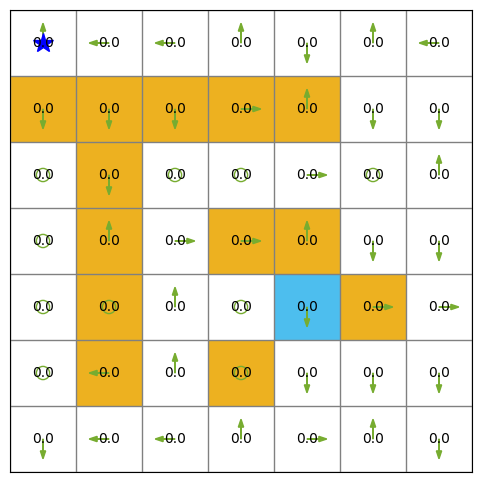

Final Policy:
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.

In [23]:
env = GridWorld()
env.reward_step = 0
env.reward_target = 100

agent = DQN(env, epsilon=0.2, gamma=0.99, num_episodes=100, episode_length=1000)
agent.run()
agent.render_static()

print("Final Policy:")
print(agent.get_policy())